In [19]:
from IPython.display import Image, Video
from agents import *
from utils import EpsilonGreedy
from utils.agent_metrics_comparer import AgentMetricsComparer
import pandas as pd

## Libs

- numpy
- matplotlib
- gymnasium (openai gym)
- moviepy (for recording video of agent playing)
- tensorflow / tensorflow[and-cuda]

## Documentations / References.

Documentation on gym / gymnasium can be found here: [https://gymnasium.farama.org/api/env/], it has good documentation on all the functions. - Do not use the one "showed" in exam paper: [https://www.gymlibrary.dev/index.html], since it has pretty bad documentation.

# [TASK-1] Overview of the Environment.

## Grid

The taxi can move on all nodes except $X$.

For each step it takes, it will be given $-1$ rewards, if successfully deliver passenger $+20$ reward points is granted. On failure on pickup and dropoff $-10$ reward points are granted.

$$
\begin{bmatrix}
\text{RED}_{11} & x_{12} & \text{X} & x_{14} & \text{GREEN}_{15} \\
x_{21} & x_{22} & \text{X} & x_{24} & x_{25} \\
x_{31} & x_{32} & x_{33} & x_{34} & x_{35} \\
x_{41} & \text{X} & x_{43} & x_{44} & x_{45} \\
\text{YELLOW}_{51} & \text{X} & x_53 & \text{BLUE}_{54} & x_{55}
\end{bmatrix}
$$

## Actions
0: move south

1: move north

2: move east

3: move west

4: pickup passenger

5: drop off passenger

## Observation space.

The taxi can dropoff passanger on (0)$\text{RED}_{11}$, (1)$\text{GREEN}_{15}$, (2)$\text{YELLOW}_{51}$, (3)$\text{BLUE}_{54}$.
That means that the passanger can be on all these states, and additionally (4)$\text{in taxi}$.

The grid is **5x5** resulting in **25** different locations for the taxi.

$4_{destinations} * 5_{passanger_locations} * 25_{nodes} = 500_{states}$

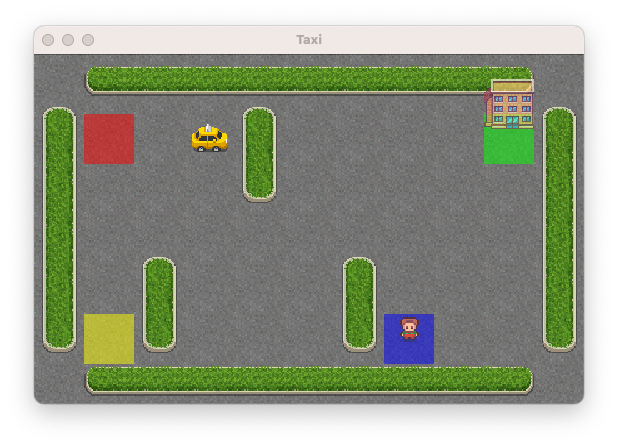

In [2]:
Image(filename='./static/Environment.png')

In [20]:
basic_params = pd.read_csv('./static/metrics/basic_tune_metrics.csv')
sarsa_params = pd.read_csv('./static/metrics/sarsa_tune_metrics.csv')

In [21]:
basic_params.describe()

,epsilon_decay,learning_rate,discount_factor,score_min,score_avg,score_max,step_min,step_avg,step_max,time_min,time_avg,time_max
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.0,200.000000,200.000000,200.000000
mean,0.826428,0.714423,0.777104,-789.410000,-18.809303,14.975000,6.025000,31.893423,200.0,0.000047,0.000227,0.001590
std,0.036342,0.143631,0.174413,60.005208,16.477967,0.353553,0.353553,13.629906,0.0,0.000003,0.000094,0.000059
min,0.800062,0.101503,0.100295,-929.000000,-162.588000,10.000000,6.000000,27.202000,200.0,0.000045,0.000191,0.001439
25%,0.807165,0.724437,0.773639,-830.000000,-16.318667,15.000000,6.000000,27.698667,200.0,0.000046,0.000196,0.001554
50%,0.813305,0.769243,0.833918,-794.000000,-13.822333,15.000000,6.000000,28.236333,200.0,0.000046,0.000201,0.001574
75%,0.826992,0.788406,0.872260,-749.000000,-13.113500,15.000000,6.000000,29.799500,200.0,0.000047,0.000213,0.001613
max,0.996316,0.799971,0.986995,-650.000000,-12.508000,15.000000,11.000000,164.316000,200.0,0.000079,0.001138,0.001840


In [22]:
sarsa_params.describe()

,epsilon_decay,learning_rate,discount_factor,score_min,score_avg,score_max,step_min,step_avg,step_max,time_min,time_avg,time_max
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.0,200.0,200.000000,200.0,200.000000,200.000000,200.000000
mean,0.832731,0.715779,0.736998,-798.645000,-18.109467,15.0,6.0,31.429577,200.0,0.000047,0.000224,0.001593
std,0.037603,0.139501,0.161076,58.302874,13.169704,0.0,0.0,9.694387,0.0,0.000002,0.000065,0.000071
min,0.800007,0.113120,0.110801,-965.000000,-109.262667,15.0,6.0,27.274667,200.0,0.000045,0.000190,0.001428
25%,0.811286,0.722912,0.699103,-839.000000,-16.323667,15.0,6.0,27.839833,200.0,0.000045,0.000198,0.001544
50%,0.820748,0.770109,0.771728,-803.000000,-13.891000,15.0,6.0,28.304333,200.0,0.000046,0.000204,0.001574
75%,0.834069,0.790135,0.847828,-758.000000,-13.241167,15.0,6.0,29.568333,200.0,0.000047,0.000217,0.001630
max,0.997323,0.799997,0.985463,-659.000000,-12.394667,15.0,6.0,103.230667,200.0,0.000051,0.000719,0.001821


In [31]:
import numpy as np
basic_hyper = basic_params.loc[np.argmax(basic_params['score_avg'])]
sarsa_hyper = sarsa_params.loc[np.argmax(sarsa_params['score_avg'])]

In [32]:
agents = {
    'random': RandomPolicyAgent(),
    'heuristic': HeuristicPolicyAgent(),
    'basic': BasicQAgent(EpsilonGreedy(1.0, basic_hyper['epsilon_decay'], 0.0), basic_hyper['learning_rate'], basic_hyper['discount_factor']),
    'sarsa': SarsaAgent(EpsilonGreedy(1.0, sarsa_hyper['epsilon_decay'], 0.0), sarsa_hyper['learning_rate'], sarsa_hyper['discount_factor']),
    'dql': DeepQAgent(EpsilonGreedy(1.0, 0.998, 0.0), 0.0001, 0.95, 258, 25000),
}

# Watch the agents play real-time

If you want to watch the agents solve the environment in real-time, then feel free to run the agents below. **Be aware you do need to have Pygame installed**

Else, you're free to watch a recorded video of the algorithm under its respected section below.

In [30]:
WATCH_EPISODES = 2

for name, agent in agents.items():
    agent.watch(n_episodes=2, step_limit_per_episode=40)

# Analysis of the agents performance

We've solved the environment with Q-Learning, SARSA, and Deep-Q-Learning in addition to the Random Policy and Heuristic Policy.

All agents are pre-trained with a total of **10_000 Episodes** on a computer with the specs:

**CPU**: AMD Ryzen 9 7950X3D, 32-Thread, 4.2/5.7 GHz.

**GPU**: NVIDIA GeForce RTX 4080 SUPER, 16GB GDDR6X, 2640 MHz, 10_420 Cuda Cores. (Used for training the Neural Net with TensorFlow)

**RAM**: DDR5 6000MHz 64GB, AMD EXPO, CL30-36-36-76

In [4]:
metrics = AgentMetricsComparer(dir_name='static/metrics')

# Random Policy

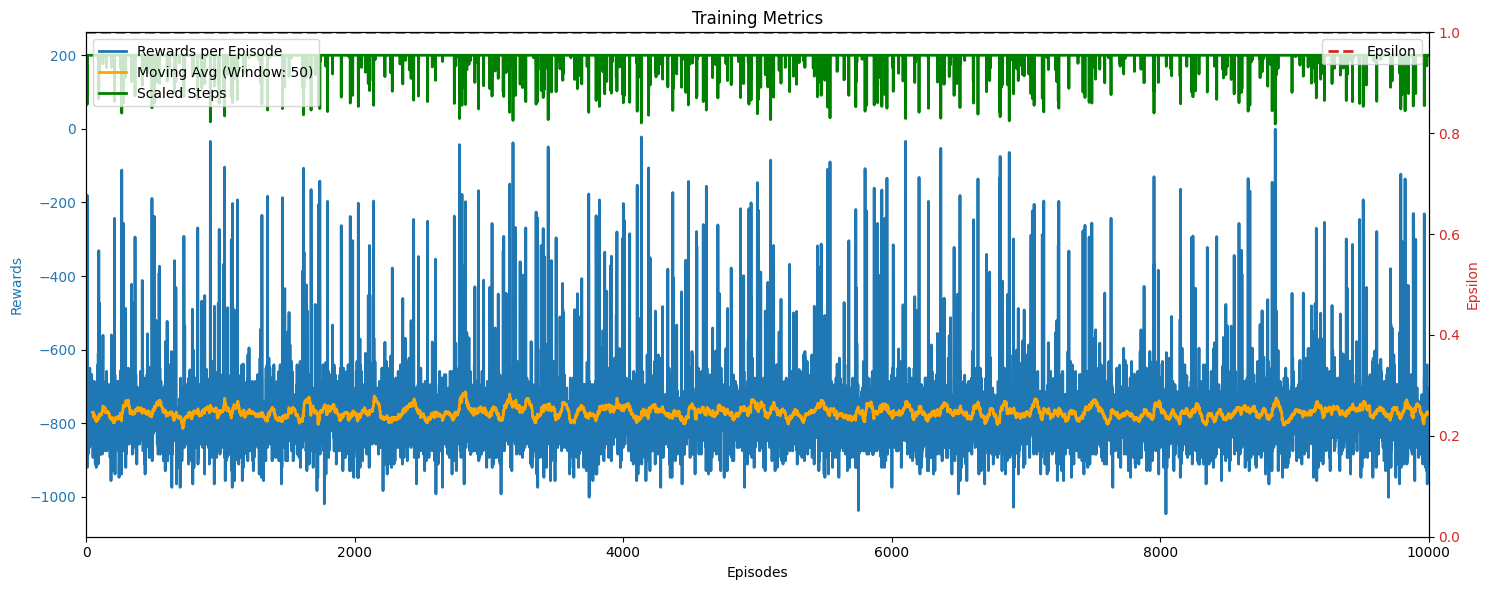

In [6]:
metrics.plot_metric('random')

In [7]:
metrics['random'].describe()

,rewards,steps,epsilon,time
count,10000.000000,10000.000000,10000.0,10000.000000
mean,-769.733800,196.514500,1.0,0.001166
std,102.514529,18.543424,0.0,0.000165
min,-1046.000000,13.000000,1.0,0.000077
25%,-821.000000,200.000000,1.0,0.001094
50%,-785.000000,200.000000,1.0,0.001113
75%,-740.000000,200.000000,1.0,0.001354
max,-1.000000,200.000000,1.0,0.001606


In [ ]:
Video('./static/movies/random/rl-video-episode-0.mp4')

# Heuristic Policy

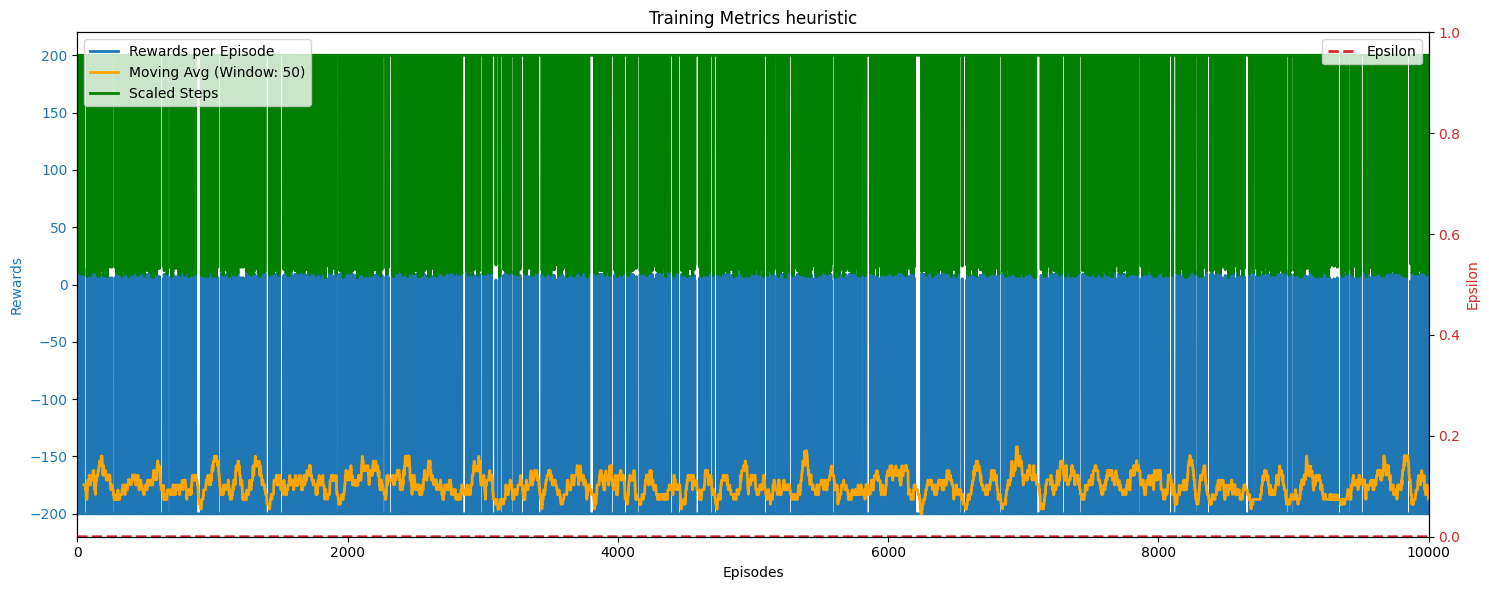

In [5]:
metrics.plot('heuristic')

In [8]:
metrics['heuristic'].describe()

,rewards,steps,epsilon,time
count,10000.000000,10000.000000,10000.0,10000.000000
mean,-174.608100,177.151200,0.0,0.000960
std,68.416201,61.565524,0.0,0.000349
min,-200.000000,6.000000,0.0,0.000035
25%,-200.000000,200.000000,0.0,0.000979
50%,-200.000000,200.000000,0.0,0.001000
75%,-200.000000,200.000000,0.0,0.001169
max,15.000000,200.000000,0.0,0.001596


In [19]:
Video('./static/movies/heuristic/rl-video-episode-0.mp4')

# Q-Learning Policy

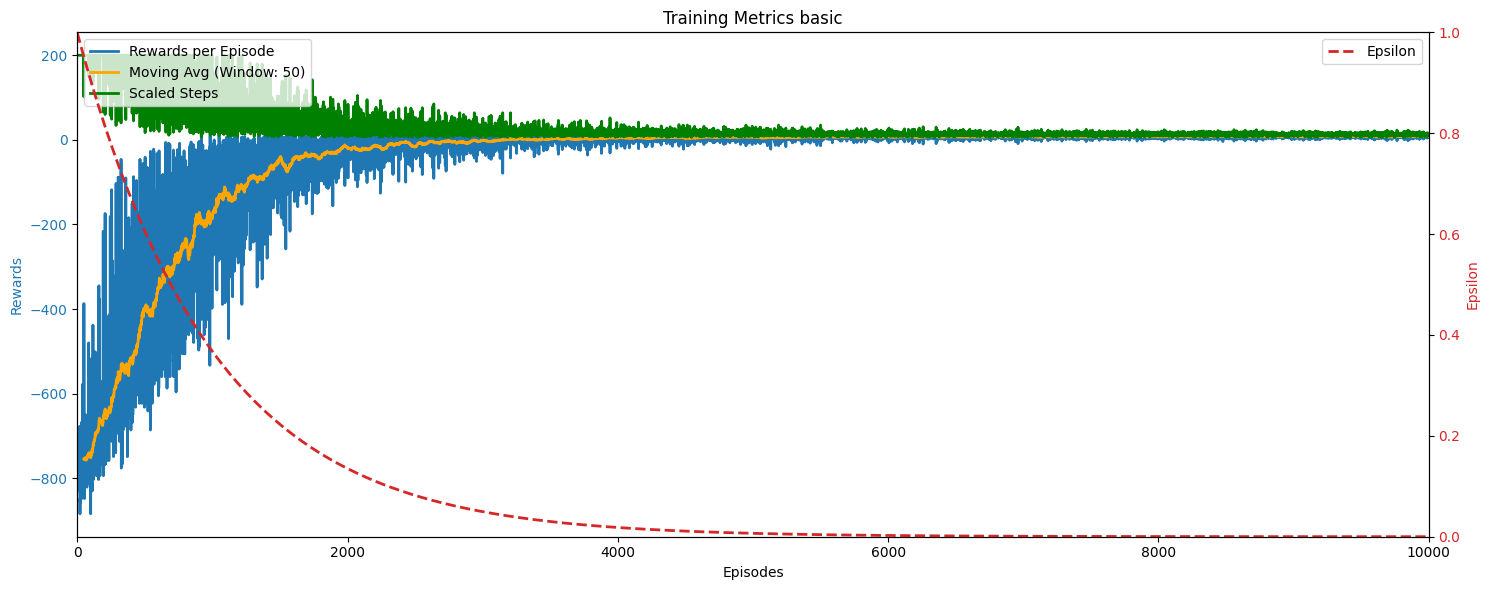

In [6]:
metrics.plot('basic')

In [9]:
metrics['basic'].describe()

,rewards,steps,epsilon,time
count,10000.000000,10000.00000,10000.000000,10000.000000
mean,-47.067800,33.03710,0.099895,0.000265
std,153.287267,47.25813,0.199875,0.000396
min,-884.000000,6.00000,0.000045,0.000047
25%,-6.000000,12.00000,0.000551,0.000093
50%,5.000000,15.00000,0.006718,0.000115
75%,9.000000,23.00000,0.081921,0.000177
max,15.000000,200.00000,0.999000,0.001994


In [16]:
Video('./static/movies/basic/rl-video-episode-0.mp4')

# SARSA Policy

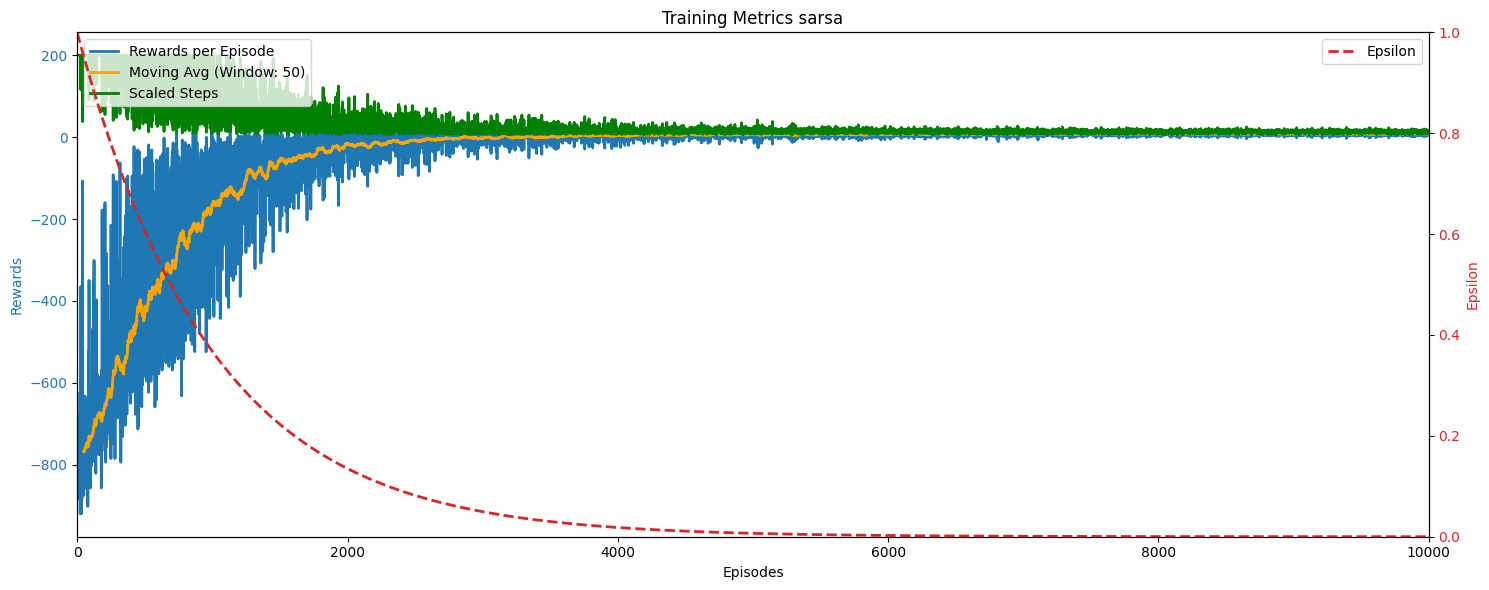

In [7]:
metrics.plot('sarsa')

In [10]:
metrics['sarsa'].describe()

,rewards,steps,epsilon,time
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,-47.026500,33.012600,0.099895,0.000257
std,153.207526,47.215929,0.199875,0.000400
min,-920.000000,6.000000,0.000045,0.000046
25%,-6.000000,12.000000,0.000551,0.000091
50%,5.000000,15.000000,0.006718,0.000112
75%,9.000000,23.000000,0.081921,0.000168
max,15.000000,200.000000,0.999000,0.002463


In [17]:
Video('./static/movies/sarsa/rl-video-episode-0.mp4')

# Deep Q Network

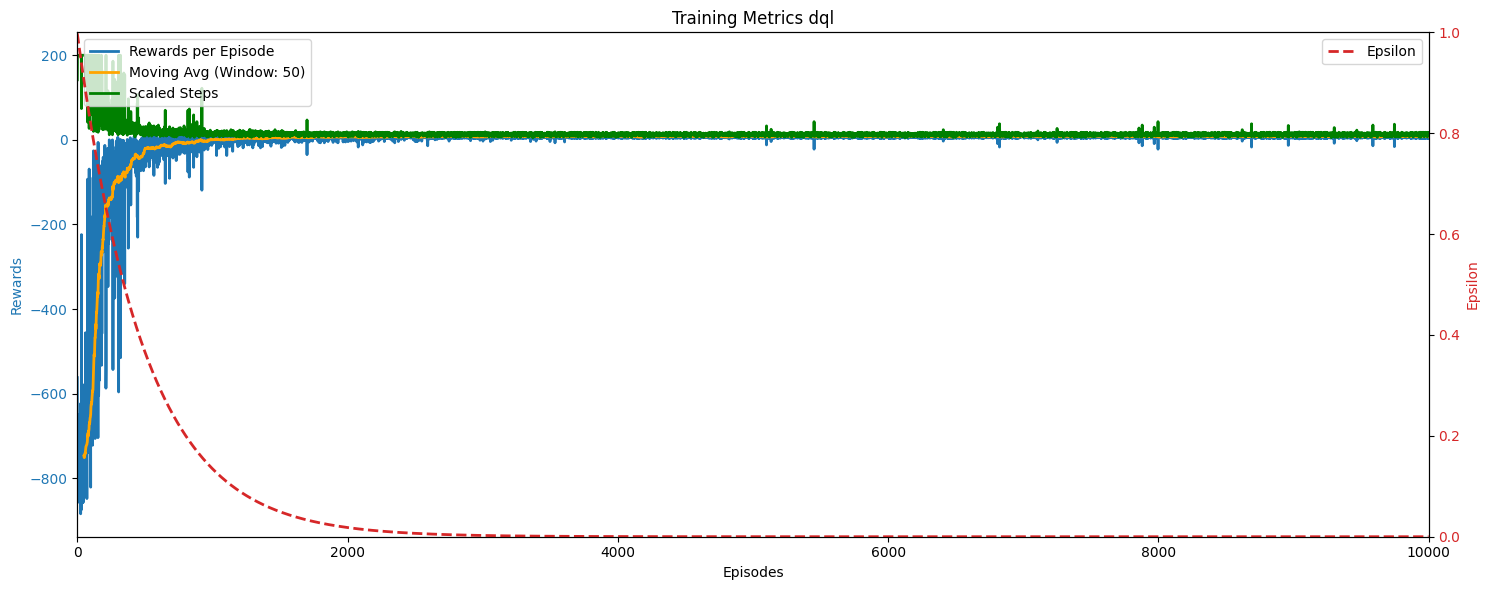

In [8]:
metrics.plot('dql')

In [15]:
metrics['dql'].describe()

,rewards,steps,epsilon,time
count,10000.000000,10000.000000,1.000000e+04,10000.000000
mean,-5.745500,16.871300,4.990000e-02,0.052715
std,82.574915,22.092396,1.497907e-01,0.040528
min,-884.000000,6.000000,2.020286e-09,0.001154
25%,5.000000,12.000000,3.011913e-07,0.040592
50%,7.000000,14.000000,4.490265e-05,0.047573
75%,9.000000,16.000000,6.694240e-03,0.054663
max,15.000000,200.000000,9.980000e-01,1.453364


In [18]:
Video('./static/movies/dql/rl-video-episode-0.mp4')

# Model comparison against Heuristic & Random Policy

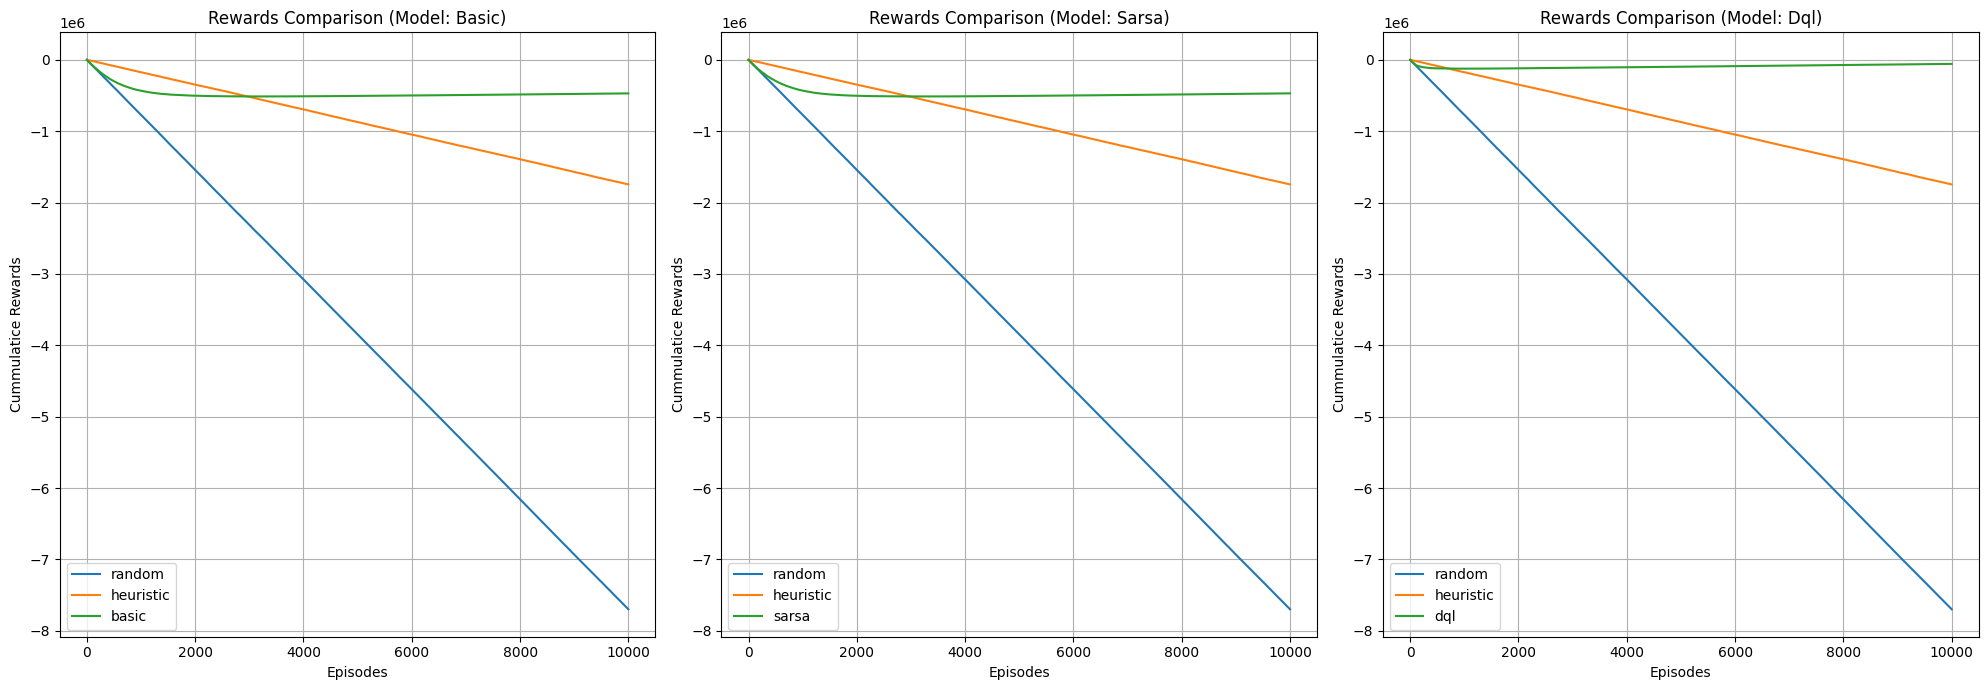

In [9]:
metrics.compare_rewards(['basic', 'sarsa', 'dql'], fig_size=(20, 7))

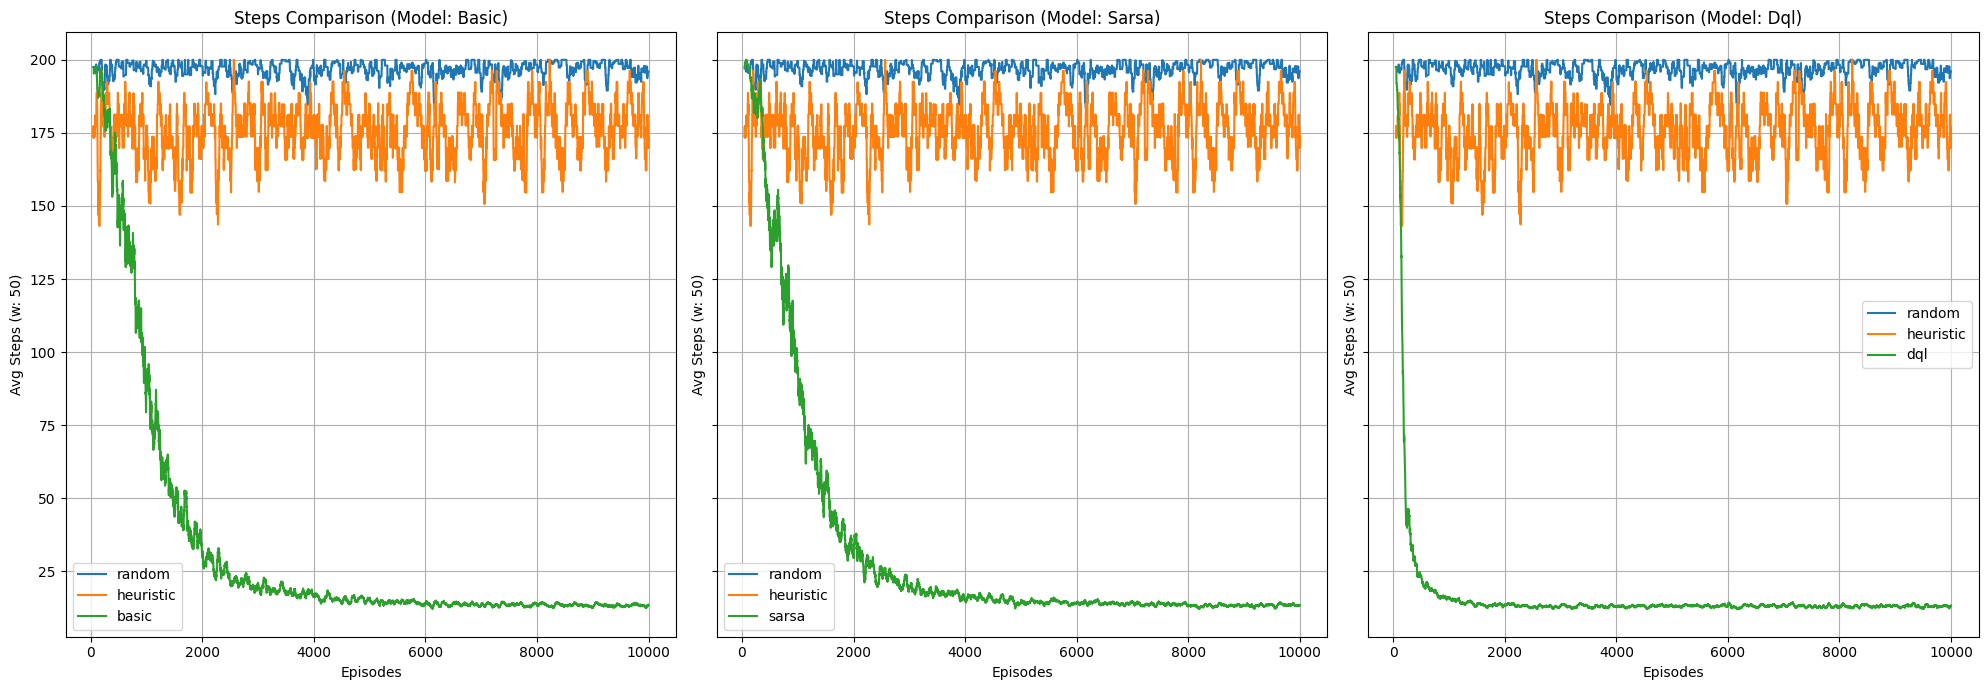

In [10]:
metrics.compare_steps(['basic', 'sarsa', 'dql'], fig_size=(20, 7))

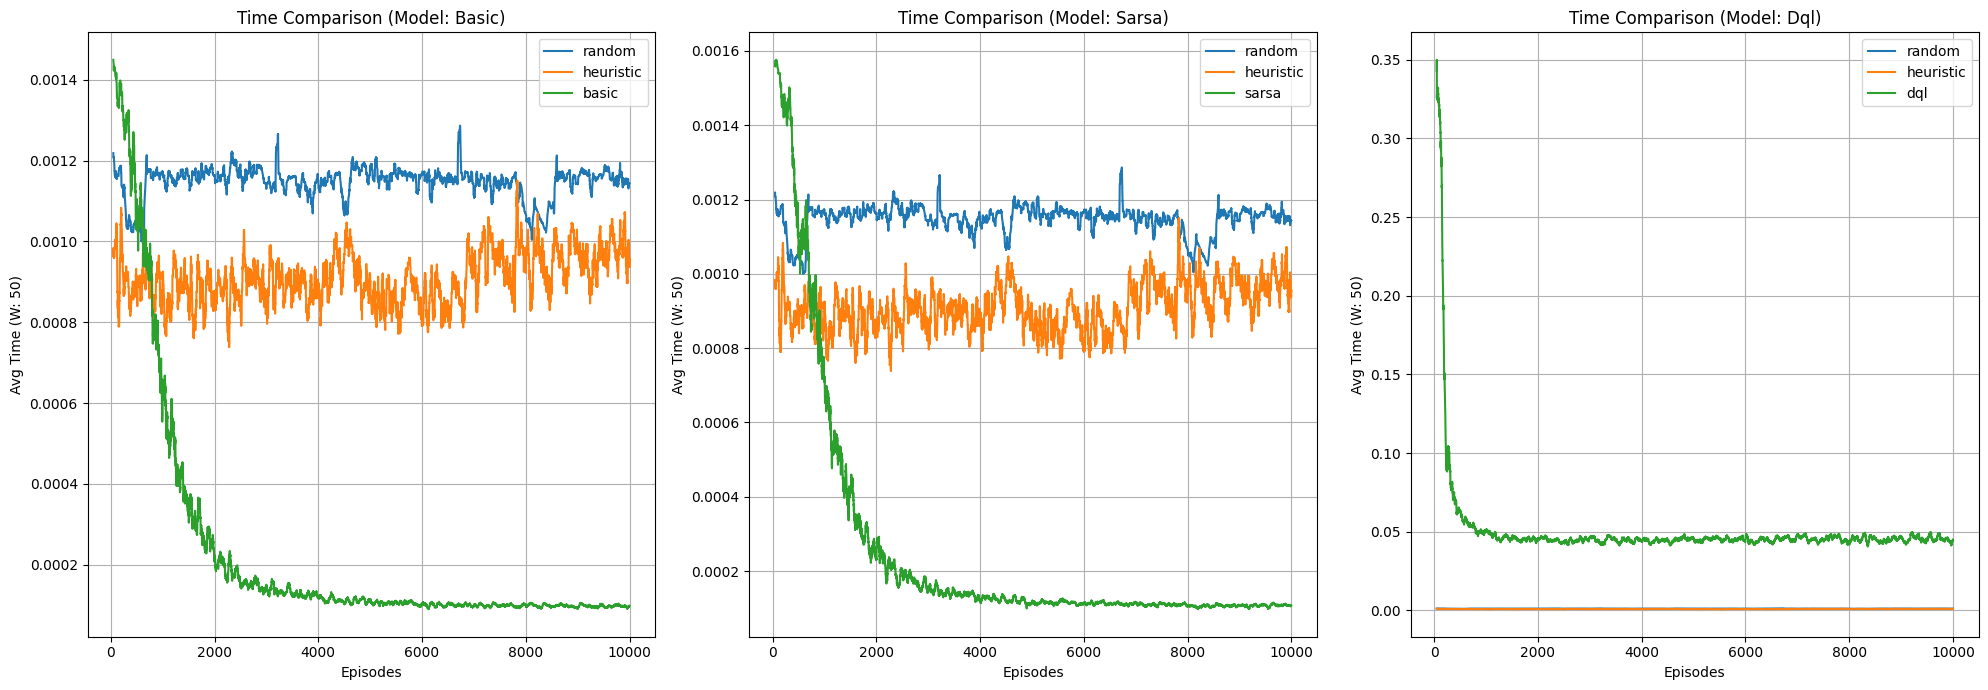

In [11]:
metrics.compare_time(['basic', 'sarsa', 'dql'], fig_size=(20, 7))

# Train the agents yourself.
If you want to train the agents yourself, feel free to do so by running the cell below. This will update the saved weight & metrics, thus if you re-run this notebook, the analysis / graphs will probably differ a bit.

**NB: Make sure to uncomment the train function first then**.

Feel free to adjust the number of episodes by tweaking the --episodes param.

In [ ]:
import train
from utils import create_progress_tracker
N_EPISODES = 2_500
N_RECORD = 3

for name, agent in agents.items():
    metrics = agent.train(N_EPISODES, 200, create_progress_tracker(name.upper()))
    metrics.save(f'./static/metrics/{name}.csv')
    agent.record_video(N_RECORD, f'./static/movies/{name}')

RANDOM


/home/jensen/miniconda3/envs/acit4610_4/lib/python3.11/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /home/jensen/ACIT/ACIT4610/Exam/ACIT4610_Portifolio_KMHS/problem_4/static/movies/random folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


HEURISTIC


/home/jensen/miniconda3/envs/acit4610_4/lib/python3.11/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /home/jensen/ACIT/ACIT4610/Exam/ACIT4610_Portifolio_KMHS/problem_4/static/movies/heuristic folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


BASIC
SARSA0/2500|##################################################|100.0% Complete. Elapsed 0.4s.


/home/jensen/miniconda3/envs/acit4610_4/lib/python3.11/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /home/jensen/ACIT/ACIT4610/Exam/ACIT4610_Portifolio_KMHS/problem_4/static/movies/basic folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


/home/jensen/miniconda3/envs/acit4610_4/lib/python3.11/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /home/jensen/ACIT/ACIT4610/Exam/ACIT4610_Portifolio_KMHS/problem_4/static/movies/sarsa folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


DQL
